# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 3 - Regression Modeling to Forecast Bike Sharing Usage



**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Chris Tanner

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

<hr style="height:2pt">

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Polynomial Regression, Ridge and Lasso Regression </div>

### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. Your task is to prepare a short report summarizing your findings and make recommendations.

The predicted hourly demand could be used for planning the number of bikes that need to be available in the system at any given hour of the day. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore ridge and lasso regression to predict bike usage. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on all available information given to you. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).



### Use only the libraries below:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

from pandas.plotting import scatter_matrix

### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will first add features that will help with the analysis and then separate the data into training and test sets. Each row in this file represents the number of rides by registered users and casual users in a given hour of a specific date. There are 12 attributes in total describing besides the number of users the weather if it is a holiday or not etc: 


- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius, normalized)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius, normalized)
- `hum` (relative humidity, normalized)
- `windspeed` (wind speed, normalized)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

<div class="exercise"> <b> Question 1 [6pts]: Data Read-In and Processing </b> </div>

In this section, we read in the data and begin one of the most important analytic steps: verifying that the data is what it claims to be.

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df_raw`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**Hint:** http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011, 1 for 2012, etc.
- `month` with 1 through 12, with 1 denoting January.
- `counts` with the total number of bike rentals for that **hour** (this is the response variable for later).

### Answers

**1.1 Load the dataset from the csv file...**

In [3]:
bikes_df_raw = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df_raw.dtypes)
bikes_df_raw.describe()

dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


All the data types seem to make sense but the one interesting thing is the standard deviation of registered users. It seems quite large compared to the other standard deviations and compared to the quantiles for registered users.

**1.2 Notice that the variable in column...**

In [4]:
bikes_df_raw["dteday"] = pd.to_datetime(bikes_df_raw["dteday"])

# to verify that it changed
print(bikes_df_raw["dteday"].dtypes)

datetime64[ns]


**1.3 Create three new columns in the dataframe:...**

In [5]:
# creating lists of years, months, and counts

year = []
month = []
counts = []

# going through every index in dataframe and appending info to respective lists
for i in range(0, len(bikes_df_raw["dteday"])):
    year.append(1*(bikes_df_raw["dteday"][i].year == 2012))
    month.append(bikes_df_raw["dteday"][i].month)
    counts.append(bikes_df_raw["casual"][i] + bikes_df_raw["registered"][i])

# adding data to new columns
bikes_df_raw["year"] = year
bikes_df_raw["month"] = month
bikes_df_raw["counts"] = counts

---

<div class='exercise'> <b> Question 2 [20 pts]: Exploratory Data Analysis. </b></div>

In this question we begin hunting for patterns in ridership that shed light on who uses the service and why.

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being just **one** day: 

- `dteday`, the timestamp for that day (fine to set to noon or any other time) 
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals of that day

Name this dataframe `bikes_by_day`.

Make a plot showing  the _distribution_ of the number of casual and registered riders on each day of the week.

**Hint:** helpful to use panda's `.groupby()` command

**2.2** Use `bikes_by_day` to visualize how the distribution of **total number of rides** per day (casual and registered riders combined) varies with the **season**. Do you see any **outliers**? Here we use the pyplot's boxplot function definition of an outlier as any value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or a significant event (an online search of those date(s) might help). 

**2.3** Convert the categorical attributes ('season', 'month', 'weekday', 'weather') into multiple binary attributes using **one-hot encoding** and call this new dataframe `bikes_df`.

**2.4** Split the updated `bikes_df` dataset into a 50-50 train-test split (call them `bikes_train` and `bikes_test`, respectively). Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set.  Use `random_state=90`, a test set size of .5, and stratify on month.  Remember to specify the data's index column as you read it in.

**2.5** Although we asked you to create your train and test set, for consistency and easy checking, we ask that for the rest of this problem set you use the train and test set provided in the files `data/BSS_train.csv` and `data/BSS_test.csv`. Read these two files into dataframes `BSS_train` and `BSS_test`, respectively. Remove the `dteday` column from both the train and the test dataset (its format cannot be used for analysis). 

**2.6** Use pandas' `scatter_matrix` command to visualize the inter-dependencies among the list of predictors listed below in the training dataset. Note and comment on any strongly related variables. [This may take a few minutes to run. You may wish to comment it out until your final submission, or only plot a randomly-selected 10% of the rows]

`cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow', 'Storm', 'Cloudy']`

**2.7** Make a plot showing the _average_ number of casual and registered riders during each hour of the day. `.groupby` and `.aggregate` should make this task easy. Comment on the trends you observe. 

**2.8** Use the one-hot-encoded `weather` related variables to show how each weather category affects the relationships in question 2.6.  Remember you should have four plots, one for each weather type (Cloudy, Storm, Snow, and Clear), even though there are only three columns related to weather after one-hot-encoding. What do you observe?

### Answers

**2.1 Make a new dataframe...**

In [6]:
# following lab 4
bikes_by_day = bikes_df_raw.groupby("dteday").agg({
    "weekday": "mean",
    "weather": "max",
    "season": "mean",
    "temp": "mean",
    "atemp": "mean",
    "windspeed": "mean",
    "hum": "mean",
    "casual": "sum",
    "registered": "sum",
    "counts": "sum"
})

bikes_by_day.head()

,weekday,weather,season,temp,atemp,windspeed,hum,casual,registered,counts
dteday,,,,,,,,,,
2011-01-01,6,3,1,0.344167,0.363625,0.160446,0.805833,331,654,985
2011-01-02,0,3,1,0.363478,0.353739,0.248539,0.696087,131,670,801
2011-01-03,1,1,1,0.196364,0.189405,0.248309,0.437273,120,1229,1349
2011-01-04,2,2,1,0.200000,0.212122,0.160296,0.590435,108,1454,1562
2011-01-05,3,1,1,0.226957,0.229270,0.186900,0.436957,82,1518,1600


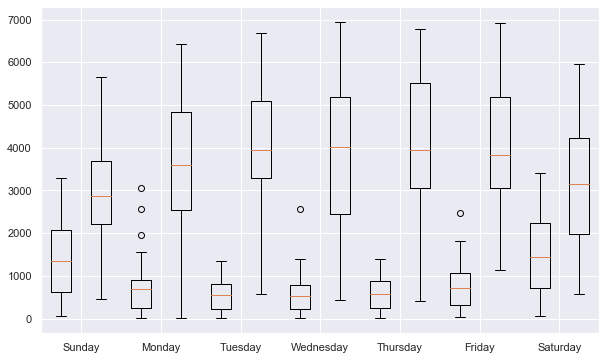

In [7]:
# Plotting
import seaborn as sns
sns.set() 

fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# creating casual and registered lists grouped by days of the week
casual_list = []
registered_list = []

# goes through day dataframe, groups by day of the week, and makes each element into one element of the respective list
for cur_val, cur_df in bikes_by_day.groupby("weekday"):
    casual_list.append(cur_df["casual"])
    registered_list.append(cur_df["registered"])

    
# plotting them (left boxes are casual, right boxes are registered)
plt.boxplot(casual_list, positions = [0, 2, 4, 6, 8, 10, 12]);
plt.boxplot(registered_list, positions = [1, 3, 5, 7, 9, 11, 13]);

axes.set_xticks(list(np.arange(0.5, 14, 2)))
axes.set_xticklabels(['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);

**2.2 Use `bikes_by_day` to visualize how the distribution...**

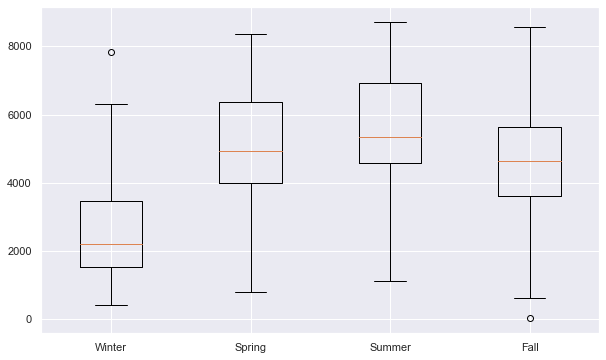

In [8]:
# following same format as 2.1
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# creating counts lists grouped by seasons
counts_list = []

# goes through day dataframe, groups by season, and makes each element into one element of the respective list
for cur_val, cur_df in bikes_by_day.groupby("season"):
    counts_list.append(cur_df["counts"])
    
# plotting counts
plt.boxplot(counts_list);
# , positions = [0, 2, 4, 6, 8, 10, 12]

# axes.set_xticks(list(np.arange(0.5, 14, 2)))
axes.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall']);

In [9]:
# trying to identify dates - would be max during winter and min during fall

# Want date where season = 1 and max count
winter_df = bikes_df_raw[bikes_df_raw['season'] == 1]
sorted_winter_df = winter_df.sort_values(by=['counts'], ascending=False)
sorted_winter_df.iloc[0,0]  # the date

# Want date where season = 4 and min count
fall_df = bikes_df_raw[bikes_df_raw['season'] == 4]
sorted_fall_df = fall_df.sort_values(by=['counts'])
sorted_fall_df.iloc[0,0]  # the date

print("The first outlier is on ", sorted_winter_df.iloc[0,0])
print("The second outlier is on ", sorted_fall_df.iloc[0,0])

The first outlier is on  2012-03-19 00:00:00
The second outlier is on  2011-12-02 00:00:00


After looking up these dates, it would seem like these were chance occurences because nothing significant happened on these days.

**2.3 Convert the categorical attributes...**

In [10]:
# following lab
bikes_df = pd.get_dummies(bikes_df_raw, columns = ['season', 'month', 'weekday', 'weather'], drop_first=True)
bikes_df.head()

,dteday,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
0,2011-01-01,0,0,0,0.24,0.2879,0.81,0.0,3,13,...,0,0,0,0,0,0,1,0,0,0
1,2011-01-01,1,0,0,0.22,0.2727,0.80,0.0,8,32,...,0,0,0,0,0,0,1,0,0,0
2,2011-01-01,2,0,0,0.22,0.2727,0.80,0.0,5,27,...,0,0,0,0,0,0,1,0,0,0
3,2011-01-01,3,0,0,0.24,0.2879,0.75,0.0,3,10,...,0,0,0,0,0,0,1,0,0,0
4,2011-01-01,4,0,0,0.24,0.2879,0.75,0.0,0,1,...,0,0,0,0,0,0,1,0,0,0


**2.4 Split the updated `bikes_df` dataset into a 50-50 train-test split...** 

In [11]:
# following lab 4
# create stratified month list
month_stratify = bikes_df_raw['month']

# split into train and test data
bikes_train, bikes_test = train_test_split(bikes_df, test_size = 0.5, random_state=90, stratify=month_stratify)

# checking the shape
# bikes_train.shape, bikes_test.shape

**2.5 Although we asked you to create your train and test set...**

In [12]:
# reading in data
BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv')

# dropping dteday column from both datafreames
BSS_train = BSS_train.drop(['dteday'], axis=1)
BSS_test = BSS_test.drop(['dteday'], axis=1)


**2.6 Use pandas' `scatter_matrix` command to visualize...**

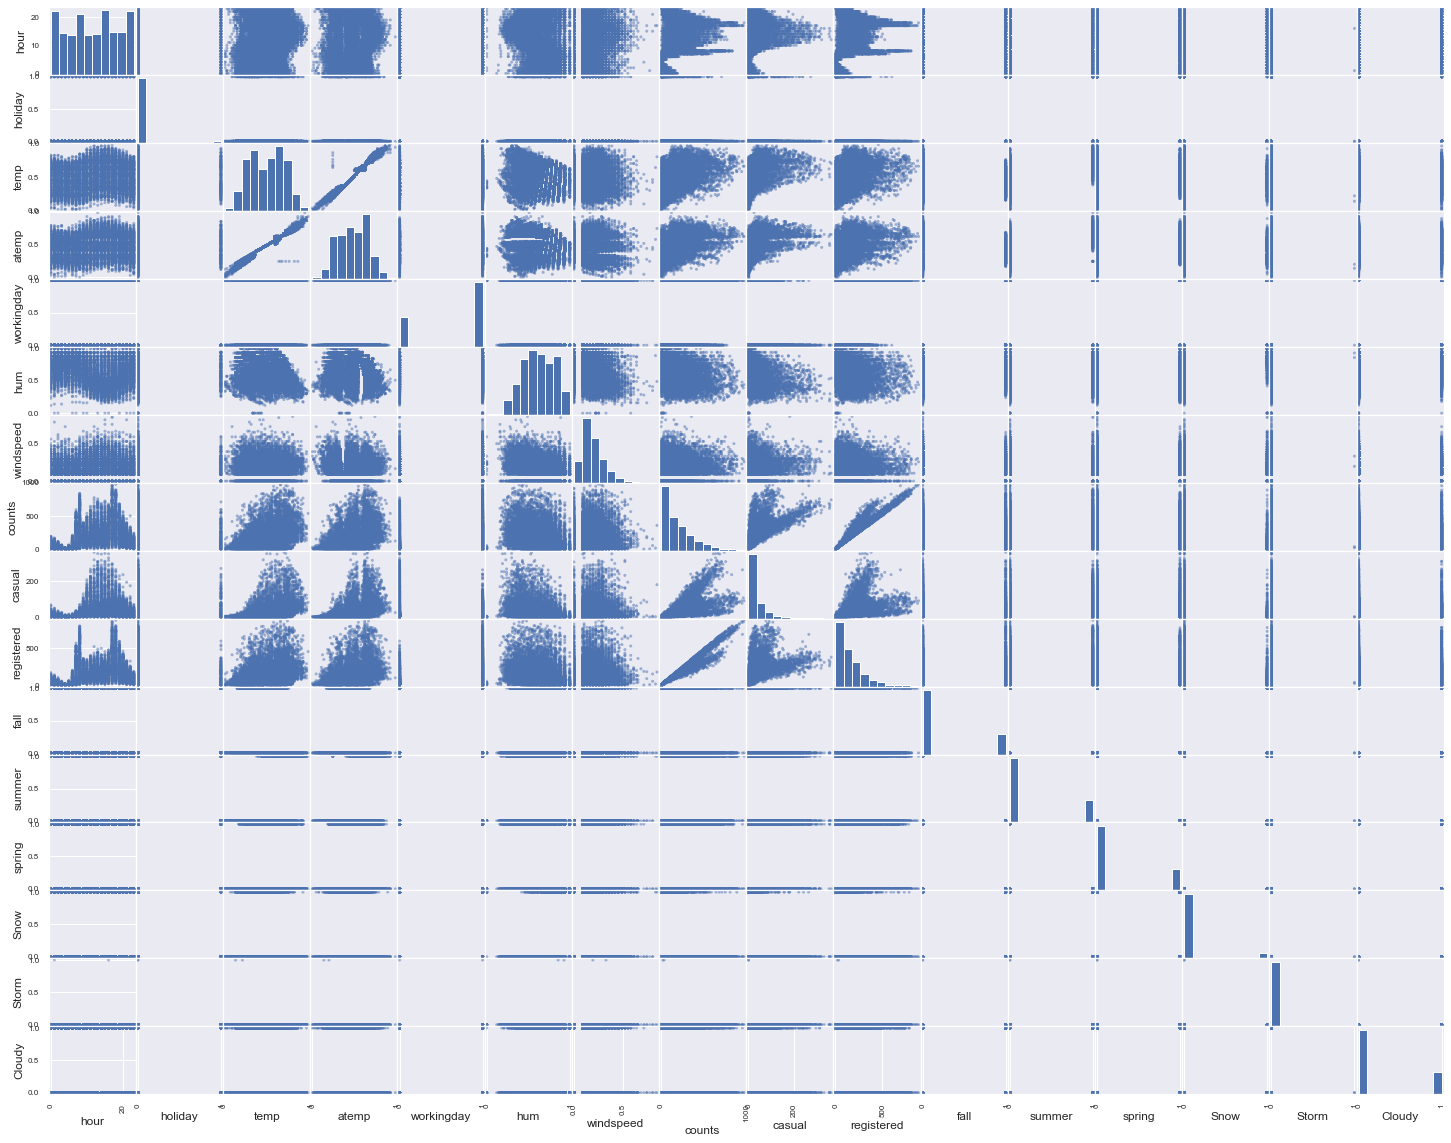

In [13]:
# using subset
# defining subset
cor_columns = ['hour', 'holiday', 'temp', 'atemp', 
               'workingday', 'hum', 'windspeed', 
               'counts', 'casual', 'registered',
               'fall', 'summer', 'spring', 
               'Snow','Storm', 'Cloudy']

# checking if it works
# BSS_train[cor_columns].head()

scatter_matrix(BSS_train[cor_columns], figsize=(25,20))
plt.show()

# actual scatter matrix
# pd.scatter_matrix(BSS_train, figsize=(25,20))
# plt.show()

The strongly related variables seem to be hour, temp, atemp, hum, windspeed, counts, casual, and registered.

**2.7 Make a plot showing the _average_ number of casual and registered riders...**

In [14]:
# create dataframe grouped by hour, contains average of casual and registered
bikes_by_hour = BSS_train.groupby("hour").agg({
    "casual": "mean",
    "registered": "mean",
})

# testing to see what it looks like
# bikes_by_hour.loc[1,"casual"]
# bikes_by_hour

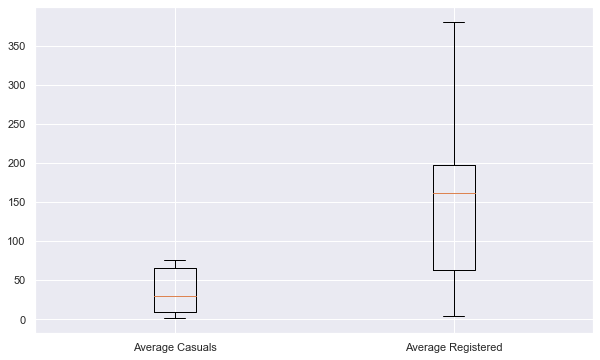

In [15]:
# following similar format to 2.1
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# creating average casual and registered lists grouped by days of the week
avg_casual_list = []
avg_registered_list = []

# goes through hour dataframe and makes each element into one element of the respective list
# go by casual then registered
for cur_val in bikes_by_hour:
    # go value by value
    for i in range(0,len(bikes_by_hour)):
        if cur_val == "casual":
            avg_casual_list.append(bikes_by_hour.loc[i,"casual"])
        else:
            avg_registered_list.append(bikes_by_hour.loc[i,"registered"])
    
# plotting them
plt.boxplot(avg_casual_list, positions = [0]);
plt.boxplot(avg_registered_list);

axes.set_xticklabels(['Average Casuals','Average Registered']);

Neither the average casuals nor the average registered counts seem to follow normal trends but they are approximately normal. Average casual seems to be more right skewed but it seems safe to assume approximate normality. As for the registered graph, it seems pretty right skewed so assuming normality may be less appropriate.

**2.8 Use the weather related variables to show how each weather...** 

How to understand using clear as a variable? Are we creating a weather dataframe?

In [16]:
# your code here

---

<div class='exercise'> <b> Question 3 [18pts]: Multiple Linear Regression to Predict Hourly Ridership </b> </div>


**3.1** Use statsmodels to fit a multiple linear regression model to the training set using all the useable predictors (nothing that `count` was derived of and no interactions or polynomial terms) to predict `counts`, and report its $R^2$ score on the train and test sets.  Call this set of predictors `X_train`.

**3.2** Examine the estimated coefficients and report which ones are statistically significant at a significance level of 5% (p-value < 0.05). 

**3.3** You should see some strange estimates for the predictors representing months.  Carefully interpret the `July` coefficient, and explain why this result is likely occurring (be as specific as possible). 

**3.4** To diagnose the model, make two plots: first a histogram of the residuals, and second a plot of the residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Draw a horizontal line denoting the zero residual value on the Y-axis. What do the plots reveal about the OLS assumptions (linearity, constant variance, and normality)?

**3.5** Perhaps we can do better via a model with polynomial terms. Build a dataset `X_train_poly` from your `X_train` data from question 3.1 with added $x^2$ terms for `temp`, `hour`, and `humidity`. Are these polynomial terms important? How does predicted ridership change as each of `temp`, `hour`, and `humidity` increase?

**3.6** You should have received a warning regarding the presence of _multicolinearity_ in the model in 3.1.  Create a new dataset `X_train_drop` by dropping the following predictors from `X_train`:  `workingday` `atemp` `spring` `summer` and `fall` and fit a multiple linear regression model to the variables the remain.  Are the estimates more sensible in this model?  And explain in your own words why multicolinearity can lead to erroneous coefficient values.



### Answers

**3.1 Use statsmodels to fit a multiple linear regression model...**

In [17]:
# following lab 4
# list of predictors is BSS_train without casual, registered, and counts
X_train = BSS_train.drop(['casual', 'registered', 'counts'], axis=1)
X_test = BSS_test.drop(['casual', 'registered', 'counts'], axis=1)

# create model using training data
model_31 = OLS(BSS_train['counts'], sm.add_constant(X_train)).fit()

# predict on X_test
prediction_31 = model_31.predict(sm.add_constant(X_test))

# r^2 score for test data
# test_score = r2_score(BSS_test[['counts']].values, prediction_31)

# r^2 score for training data
# train_score = model_31.rsquared

print("The R^2 for the training data is ", model_31.rsquared)
print("The R^2 for the test data is ",  r2_score(BSS_test[['counts']].values, prediction_31))

The R^2 for the training data is  0.4115699822629325
The R^2 for the test data is  0.40072109229413466


C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


**3.2 Examine the estimated coefficients and report...**

In [18]:
# estimated coefficients are in the summary
model_31.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     201.9
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:16:33   Log-Likelihood:                -55215.
No. Observations:                8689   AIC:                         1.105e+05
Df Residuals:                    8658   BIC:                         1.107e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -30.4075     10.908     -2.788      0.005     -51.789      -9.026
hour           7.2092      0.233     30.975      0.000       6.753       7.665
holiday      -19.1510      8.369     -2.288      0.022     -35.556      -2.746
year          78.1211      3.020     25.864      0.000      72.200      84.042
workingday    10.9484      3.512      3.118      0.002       4.065      17.832
temp         273.6625     61.680      4.437      0.000     152.755     394.570
atemp        162.5353     64.909      2.504      0.012      35.298     289.773
hum         -202.0080      9.927    -20.349      0.000    -221.468    -182.548
windspeed     19.3827     13.595      1.426      0.154      -7.268      46.033
spring        50.0754      9.528      5.256      0.000      31.398      68.753
summer        22.6879     11.138      2.037      0.042       0.855      44.521
fall          70.9474      9.448      7.509      0.000      52.426      89.469
Feb          -10.7198      7.590     -1.412      0.158     -25.598       4.158
Mar          -11.2938      8.385     -1.347      0.178     -27.731       5.143
Apr          -44.8326     12.635     -3.548      0.000     -69.600     -20.065
May          -50.1605     13.493     -3.718      0.000     -76.609     -23.712
Jun          -72.2042     13.700     -5.271      0.000     -99.058     -45.350
Jul          -90.8965     15.387     -5.907      0.000    -121.058     -60.735
Aug          -58.3246     15.061     -3.873      0.000     -87.847     -28.802
Sept         -16.1686     13.432     -1.204      0.229     -42.499      10.162
Oct          -15.8838     12.484     -1.272      0.203     -40.356       8.588
Nov          -32.7232     12.049     -2.716      0.007     -56.342      -9.104
Dec          -19.2088      9.560     -2.009      0.045     -37.949      -0.469
Mon           -3.3336      3.756     -0.888      0.375     -10.697       4.029
Tue           -0.0074      4.105     -0.002      0.999      -8.055       8.040
Wed           -2.2059      4.082     -0.540      0.589     -10.207       5.795
Thu           -5.5698      4.013     -1.388      0.165     -13.436       2.297
Fri            2.9140      4.015      0.726      0.468      -4.956      10.784
Sat           12.7461      5.587      2.281      0.023       1.793      23.699
Cloudy         6.9163      3.676      1.882      0.060      -0.289      14.122
Snow         -26.8155      6.094     -4.401      0.000     -38.760     -14.871
Storm         48.2045     98.839      0.488      0.626    -145.543     241.952
==============================================================================
Omnibus:                     1691.839   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3250.657
Skew:                           1.191   Prob(JB):                         0.00
Ku

All the estimated coeffcients except for `windspeed`, `Feb`, `Mar`, `Sept`, `Oct`, `Mon`, `Tue`, `Wed`, `Thu`, `Fri`, `Cloudy`, and `Storm`  are statistically significant.

**3.3 You should see some strange estimates for the predictors representing months...** 

The `July` coefficient is a very large and negative coefficient. The most basic interpretation is that this is the amount that the counts would increase in July if all other predictors are held constant. However, this value is clearly wrong. It could be that the data in July is violating some important assumptions for the *t*-test such as Normality or Linearity.


**3.4 To diagnose the model, make two plots:...**

C:\Users\kkv09\Anaconda3\envs\cs109a\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Mean of residuals: 6.993395645322105e-15


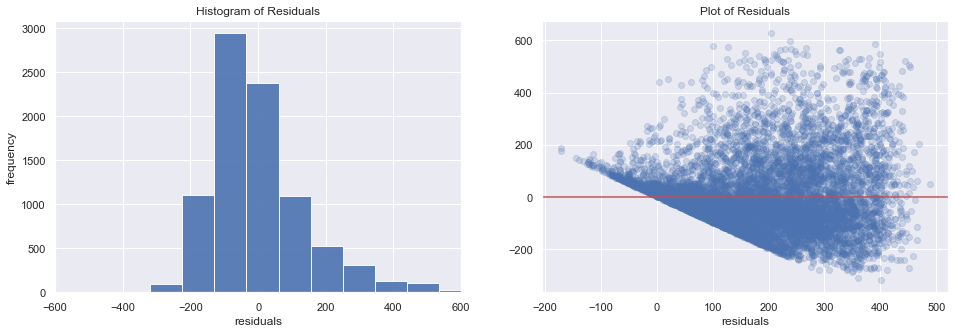

In [19]:
# following section notes
predictors = sm.add_constant(X_train)

y_hat = model_31.predict(predictors)
residuals = BSS_train['counts'] - y_hat

# creating figure
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax = ax.ravel()

# histogram of residuals
ax[0].set_title('Histogram of Residuals')
ax[0].hist(residuals, alpha=0.9)
ax[0].set_xlabel('residuals')
ax[0].set_ylabel('frequency');
ax[0].set_xlim([-600,600])

# plot of residuals
ax[1].set_title('Plot of Residuals')
ax[1].scatter(y_hat, residuals, alpha=0.2)
ax[1].set_xlabel(r'$\hat{y}$')
ax[1].set_xlabel('residuals')
ax[1].axhline(y=0, color='r', linestyle='-')

# Mean of residuals
print('Mean of residuals: {}'.format(np.mean(residuals)))

These plots reveal that we are certainly assuiming normality in the distribution of the residuals as shown in the histogram. It is also safe to say that we are assuming linearity which is pretty obvious in the symmetry and distribution of the residuals in the plot. 

**3.5 Perhaps we can do better via a model...**

In [20]:
# double checking columns - DELETE THIS
X_train.columns

Index(['hour', 'holiday', 'year', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'spring', 'summer', 'fall', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Mon', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Cloudy', 'Snow', 'Storm'],
      dtype='object')

In [21]:
# creating X_train_poly
X_train_poly = X_train

# adding x^2 terms for temp, hour, & hum
X_train_poly['temp^2'] = BSS_train['temp'] **2
X_train_poly['hour^2'] = BSS_train['hour'] **2
X_train_poly['hum^2'] = BSS_train['hum'] **2

model_35 = OLS(
    BSS_train['counts'], sm.add_constant(X_train_poly)).fit()
model_35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     271.3
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:16:34   Log-Likelihood:                -54433.
No. Observations:                8689   AIC:                         1.089e+05
Df Residuals:                    8655   BIC:                         1.092e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -193.3332     17.588    -10.992      0.000    -227.810    -158.857
hour          40.2211      0.840     47.896      0.000      38.575      41.867
holiday      -14.0310      7.656     -1.833      0.067     -29.039       0.977
year          83.2098      2.781     29.921      0.000      77.758      88.661
workingday    13.2241      3.212      4.117      0.000       6.928      19.520
temp          46.0096     78.769      0.584      0.559    -108.397     200.416
atemp        148.5309     61.182      2.428      0.015      28.599     268.463
hum           42.3171     45.426      0.932      0.352     -46.729     131.363
windspeed    -19.4101     12.531     -1.549      0.121     -43.973       5.153
spring        46.8322      8.714      5.374      0.000      29.750      63.914
summer        25.4085     10.202      2.490      0.013       5.410      45.407
fall          74.7289      8.643      8.646      0.000      57.787      91.671
Feb           -2.2754      7.037     -0.323      0.746     -16.070      11.519
Mar            9.1429      7.906      1.156      0.248      -6.355      24.641
Apr          -12.2792     11.781     -1.042      0.297     -35.373      10.814
May          -15.6791     12.489     -1.255      0.209     -40.160       8.802
Jun          -29.8762     12.639     -2.364      0.018     -54.652      -5.100
Jul          -51.5208     14.156     -3.640      0.000     -79.269     -23.773
Aug          -23.3642     13.901     -1.681      0.093     -50.613       3.884
Sept          11.0442     12.519      0.882      0.378     -13.495      35.584
Oct           -1.9320     11.682     -0.165      0.869     -24.831      20.967
Nov          -27.7996     11.221     -2.478      0.013     -49.795      -5.804
Dec          -19.1169      8.871     -2.155      0.031     -36.506      -1.728
Mon           -0.9673      3.434     -0.282      0.778      -7.699       5.764
Tue            0.9441      3.753      0.252      0.801      -6.412       8.301
Wed           -1.8581      3.731     -0.498      0.619      -9.172       5.456
Thu           -2.7283      3.669     -0.744      0.457      -9.921       4.465
Fri            3.8028      3.671      1.036      0.300      -3.393      10.999
Sat           18.1315      5.113      3.546      0.000       8.109      28.154
Cloudy        -9.5074      3.389     -2.805      0.005     -16.151      -2.864
Snow         -46.9213      5.765     -8.139      0.000     -58.222     -35.620
Storm         34.1383     90.378      0.378      0.706    -143.024     211.301
temp^2       140.6804     46.276      3.040      0.002      49.968     231.393
hour^2        -1.3881      0.034    -40.654      0.000      -1.455      -1.321
hum^2       -126.8873     36.621     -3.465      0.001    -198.673     -55.102
==============================================================================
Om

The numbers were quite low on the regular temp, hum, and hour so with their augmented forms, they seem to have numbers that make much more sense. They are quite large in magnitude which is in line with the ridership levels. It is interesting, however, that hour and hum both become negative.

**3.6 You should have received a warning regarding the presence of _multicollinearity_...**

In [22]:
# creating X_train_drop
X_train_drop = X_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

# create model using training data
model_35 = OLS(BSS_train['counts'], sm.add_constant(X_train_drop)).fit()

model_35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 counts   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     301.2
Date:                Wed, 09 Oct 2019   Prob (F-statistic):               0.00
Time:                        23:16:34   Log-Likelihood:                -54489.
No. Observations:                8689   AIC:                         1.090e+05
Df Residuals:                    8659   BIC:                         1.093e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -199.4641     17.612    -11.325      0.000    -233.988    -164.940
hour          40.3882      0.844     47.841      0.000      38.733      42.043
holiday      -34.1348      8.602     -3.968      0.000     -50.998     -17.272
year          82.6974      2.796     29.578      0.000      77.217      88.178
temp         238.9849     46.380      5.153      0.000     148.070     329.900
hum           50.7539     44.849      1.132      0.258     -37.162     138.669
windspeed    -35.9638     12.094     -2.974      0.003     -59.670     -12.257
Feb           -3.5135      7.079     -0.496      0.620     -17.390      10.363
Mar           21.6202      7.452      2.901      0.004       7.013      36.227
Apr           31.5125      8.132      3.875      0.000      15.573      47.452
May           26.1278      9.134      2.861      0.004       8.223      44.032
Jun            4.3640      9.877      0.442      0.659     -14.997      23.725
Jul          -29.8474     10.732     -2.781      0.005     -50.884      -8.811
Aug           -4.0427     10.206     -0.396      0.692     -24.050      15.964
Sept          43.7323      9.400      4.652      0.000      25.306      62.159
Oct           68.3455      8.356      8.180      0.000      51.966      84.725
Nov           44.1431      7.478      5.903      0.000      29.485      58.801
Dec           26.6049      7.120      3.737      0.000      12.648      40.561
Mon           14.1731      5.310      2.669      0.008       3.764      24.582
Tue           14.7113      5.221      2.817      0.005       4.476      24.946
Wed           11.2307      5.194      2.162      0.031       1.050      21.412
Thu           11.0891      5.163      2.148      0.032       0.967      21.211
Fri           16.6540      5.161      3.227      0.001       6.538      26.770
Sat           17.8177      5.143      3.465      0.001       7.737      27.898
Cloudy        -9.5167      3.407     -2.793      0.005     -16.196      -2.837
Snow         -47.3011      5.798     -8.158      0.000     -58.667     -35.935
Storm         33.4270     90.935      0.368      0.713    -144.827     211.681
temp^2        85.3965     45.544      1.875      0.061      -3.880     174.673
hour^2        -1.3948      0.034    -40.633      0.000      -1.462      -1.328
hum^2       -132.5722     36.186     -3.664      0.000    -203.505     -61.639
==============================================================================
Omnibus:                     1738.675   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3432.342
Skew:                           1.207   Prob(JB):                         0.00
Kurtosis:                       4.910   Cond. No.                     1.63e+04
==============================================================================

W

The estimates do seem to be more sensible in the model because those predictors seem to associate positively with ridership levels. Also, multicolinearity can lead to erroneous coefficient values because there could be some predictors that are interacting with each other and therefore may result in a model that is misfitting (either overfitting or underfitting) the data.

---

<div class='exercise'> <b> Question 4 [20pts]: Regression Models with Polynomial and Interaction Terms </b> </div>

**4.1** Drop the variables `workingday`, `atemp`, `spring`, `summer`, `fall`, and  `dteday` from `BSS_train` (if any of them still remain).

**4.2** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns from `X_train` into a dataset called `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**4.3** Write a code to augment your a dataset with higher-order features for `temp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `temp^2` and `hum^2` but not `temp*hum` or any other two-feature interactions. 

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**4.4** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `temp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**4.5** Combine all your code so far into a function named `get_design_mats` that takes in `BSS_train`, `BSS_test`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_test` and responses `y_train` and `y_test`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.


**4.6** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the test data.

**4.7** Discuss patterns you see in the results from 4.5. Which model would you select, and why?

### Answers

**4.1 Drop...**

In [23]:
# dropping columns from BSS_train
BSS_train = BSS_train.drop(['workingday', 'atemp', 'spring', 'summer', 'fall'], axis=1)

**4.2 Write a function to standardize...**

In [24]:
# make training data that has all non-binary X_train columns
# the columns are hour, temp, hum, windspeed, 
binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm', 'atemp', 'hour^2', 'hum^2', 'temp^2', 'year']

# added columns after Storm to be more clear for future problems

non_binary_columns = X_train.columns.difference(binary_columns)

# practice X train is a copy of all the non-binary columns from X_train
practice_X_train = X_train[non_binary_columns].copy()

def standardize_set(train_data, non_binary_columns):
    
    # Fit the scaler on practice training data
    scaler = StandardScaler().fit(train_data[non_binary_columns])

    # Scale training data binary columns - FUNCTION WILL TAKE IN practice_X_train
    train_data[non_binary_columns] = pd.DataFrame(scaler.transform(train_data[non_binary_columns]))
    
    return train_data

# checking the function
practice_X_train_scaled = standardize_set(practice_X_train, non_binary_columns)

practice_X_train_scaled.describe()

,hour,hum,temp,windspeed
count,8.689000e+03,8.689000e+03,8.689000e+03,8.689000e+03
mean,2.762461e-17,-4.148227e-16,-7.622961e-17,-5.604141e-17
std,1.000058e+00,1.000058e+00,1.000058e+00,1.000058e+00
min,-1.666359e+00,-3.251974e+00,-2.474192e+00,-1.546636e+00
25%,-8.042663e-01,-7.554808e-01,-8.122824e-01,-6.987336e-01
50%,5.782674e-02,-2.733697e-02,1.867233e-02,2.746035e-02
75%,9.199197e-01,8.048274e-01,8.496271e-01,5.118601e-01
max,1.638331e+00,1.949053e+00,2.511537e+00,5.355858e+00


**4.3 Write code to augment your a dataset with higher-order features for...**

In [25]:
practice_copy = practice_X_train_scaled

for column in practice_X_train_scaled.columns:
    column_i = practice_copy[[column]].values
    print(type(column))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [40]:
# following lab 4
# take in practice_X_train_scaled and a certain degree (number of degrees? so a list?)

def augment_dataset(scaled_train_data, degree):
    
    # copy practice_X_train_scaled INSIDE FUNCTION
    scaled_train_data_cp = scaled_train_data.copy()

    # go column by column of scaled_train_data
    for column in scaled_train_data.columns:
        
        print(column)
        
        # take column i of the copy (can do double brackets so I don't have to reshape)
        scaled_train_data_ci = scaled_train_data_cp[column].values.reshape(-1,1)
        
        # create transformer with d degrees (CHANGE THIS)
        transformer_d = PolynomialFeatures(degree, include_bias=False)
        
        # transform column to polynomial features
        expanded_column = transformer_d.fit_transform(scaled_train_data_ci)
        
        # use np.concatenate() to join the arrays and store it
#         scaled_train_data_cp = np.concatenate((scaled_train_data_cp, expanded_column), axis=1)
    
    return scaled_train_data_cp

# check if it worked
practice_X_train_poly = augment_dataset(practice_X_train_scaled, 3)   # add cubic
practice_X_train_poly = augment_dataset(practice_X_train_scaled, 4)   # add quadratic
pd.DataFrame(practice_X_train_poly).head()

hour
hum
temp
windspeed
hour
hum
temp
windspeed


,hour,hum,temp,windspeed
0,1.350966,-0.131358,-1.331629,0.511860
1,0.776238,1.064879,0.641888,0.511860
2,-0.373220,0.180704,1.368974,-0.214334
3,0.776238,-2.107748,0.641888,0.875363
4,-0.516902,-1.171563,-1.643237,-0.456939


Trying to transform each of the specified columns and adding them back to dataframe. Currently have it coded like it was in lab but I am trying to concatenate a numpy array to a dataframe. I would try to change the expanded column into a dataframe and use `pd.concatenate` to concatenate them.

**4.4 Write code to add interaction terms to the model...**

In [27]:
# def add_interactions(train_df):

#     make lists to hold the continuous variables (the first four) and the dummies variables
#     conttinuous_list = []
#     dummies_list = []

#     go through first four columns and multiply with last 
#     index through the columns of practice_X_train_poly
#     for i in range(0, len(traindf))


**4.5 Combine all your code so far into a function named...**

In [28]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts']):
    """
    :param train_df: The training data
    :param val_df: Your test/validation data
    :param columns_forpoly: List containing the column name for which we want to create 
                            polynomial terms
    :param target_col: The response variable column
    :param bad_columns: The columns you want to drop
    """
    
    # add code here 
    return x_train,y_train, x_val,y_val

**4.6 For each degree in 1 through 8...**

In [29]:
# your code here

**4.7 Discuss patterns you see in the results...**

*your answer here*

---

<div class='exercise'> <b> Question 5 [20pts]: Regularized Models </b> </div>

**5.1** Let's try regularizing our models via ridge regression. Split the training set, `BSS_train`, into an 80-20 train-validation split.  Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**5.2** Find the best-scoring degree and regularization combination.

**5.3** It's time to see how well our selected model will do on future data. Use the earlier created test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? Does the test set simply have observations that are more difficult or easier to predict?

**5.4** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you may need to increase `max_iter` (start with 100,000) for the optimization to converge.

**5.5** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**5.6** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**5.7** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Answers

**5.1 Let's try regularizing our models via...** 

In [30]:
# your code here

**5.2 Find the best-scoring degree and regularization combination.**

In [31]:
# your code here

**5.3 It's time to see how well our selected model...**


In [32]:
# your code here

**5.4 Build a dataset with polynomial degree 1...**

In [33]:
# your code here

**5.5 Plot histograms of the coefficients found...**

In [34]:
# your code here

**5.6 The plots above show the overall distribution of... **

In [35]:
# your code here

**5.7 What trends do you see...**

In [36]:
# your code here

*your answer here*

---

<div class='exercise'> <b> Question 6 [16 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**6.1** Reflect back on the `get_design_mats` function you built. In what way was writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

**6.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting polynomial features for the model?

**6.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 5, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

**6.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work?


### Answers

**6.1 Reflect back on the get_design_mats function you built...**

*your answer here*

**6.2 What are the costs and benefits of applying ridge/lasso...**

*your answer here*

**6.3 This pset posed a purely predictive goal: forecast ridership...**

*your answer here*

**6.4 Reflect back on our original goal of helping BikeShare predict...**

*your answer here*